
[INFO] Memproses exports_usd and imports_usd tahun 2000.png...
  -> Menggunakan setelan untuk tahun 2000: Y-Range(300000-850000)

[INFO] Memproses exports_usd and imports_usd tahun 2001.png...
  -> Menggunakan setelan untuk tahun 2001: Y-Range(300000-850000)

[INFO] Memproses exports_usd and imports_usd tahun 2002.png...
  -> Menggunakan setelan untuk tahun 2002: Y-Range(300000-850000)

[INFO] Memproses exports_usd and imports_usd tahun 2003.png...
  -> Menggunakan setelan untuk tahun 2003: Y-Range(300000-850000)

[INFO] Memproses exports_usd and imports_usd tahun 2004.png...
  -> Menggunakan setelan untuk tahun 2004: Y-Range(300000-850000)

[INFO] Memproses exports_usd and imports_usd tahun 2005.png...
  -> Menggunakan setelan untuk tahun 2005: Y-Range(300000-850000)

[INFO] Memproses exports_usd and imports_usd tahun 2006.png...
  -> Menggunakan setelan untuk tahun 2006: Y-Range(300000-850000)

[INFO] Memproses exports_usd and imports_usd tahun 2007.png...
  -> Menggunakan setelan u

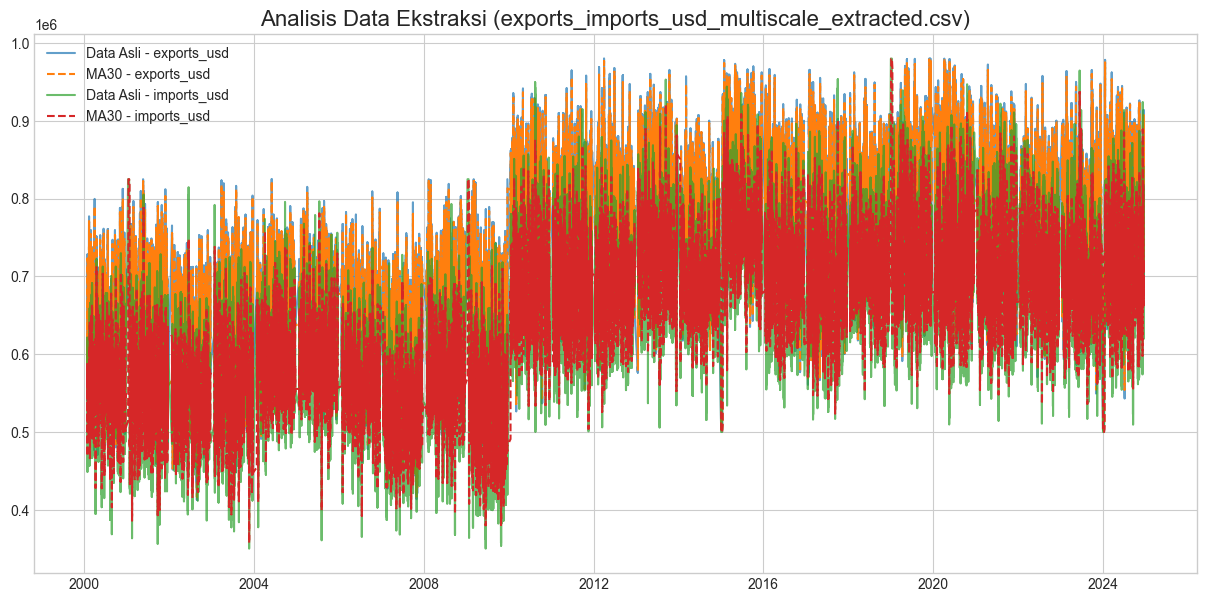


✅ SUKSES! 780989 baris data disimpan ke exports_imports_usd_multiscale_extracted.csv


In [8]:
# ==============================================================================
# Script Ekstraksi Data Grafik v3.3 (Fleksibel & Multi-Skala)
# Deskripsi:
#   Mendukung parameter fallback yang berbeda untuk rentang tahun yang berbeda,
#   meningkatkan akurasi pada dataset dengan skala sumbu Y dinamis.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================

import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# (Letakkan blok CONFIG dari atas di sini)
CONFIG = {
    "folder_path": r"C:\Users\LENOVO\Downloads\statexplore\Data\C02\exports_usd and imports_usd",
    "output_csv_file": "exports_imports_usd_multiscale_extracted.csv",
    "year_based_params": [
        {"years": range(2000, 2010), "fallback_y_min": 300000, "fallback_y_max": 850000, "clamp_y_min": 350000, "clamp_y_max": 825000},
        {"years": range(2010, 2025), "fallback_y_min": 450000, "fallback_y_max": 1000000, "clamp_y_min": 500000, "clamp_y_max": 980000}
    ],
    "variables": [
        {"name": "exports_usd", "lower_color": np.array([90, 80, 50]), "upper_color": np.array([130, 255, 255])},
        {"name": "imports_usd", "lower_color": np.array([10, 80, 80]), "upper_color": np.array([25, 255, 255])}
    ],
    "debug_mode": False,
    "visualize_output": True
}

# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU (Utility Functions)
# ==============================================================================
def is_leap(year: int) -> bool: return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def clean_mask(mask: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# ✨ BARU: Fungsi untuk mendapatkan parameter berdasarkan tahun
def get_params_for_year(year: int, config: Dict[str, Any]) -> Dict[str, float]:
    """Mencari dan mengembalikan set parameter yang sesuai untuk tahun tertentu."""
    for params in config.get("year_based_params", []):
        if year in params["years"]:
            return params
    # Jika tidak ada aturan yang cocok, gunakan aturan pertama sebagai default
    print(f"  -> Peringatan: Tidak ada aturan spesifik untuk tahun {year}, menggunakan aturan pertama.")
    return config["year_based_params"][0]

# ==============================================================================
# 3. FUNGSI EKSTRAKSI INTI (Core Extraction Functions)
# ==============================================================================
def extract_year_from_title(title_crop: np.ndarray) -> Optional[int]:
    try:
        title_text = pytesseract.image_to_string(title_crop, config="--psm 6")
        match = re.search(r'\b(20\d{2})\b', title_text)
        if match: return int(match.group(1))
    except Exception: pass
    return None

def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_y_max']), params['clamp_y_min'])
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"), "Year": params['year'],
                "DayOfYear": day_of_year + 1, params['var_name']: int(round(value, 0))
            })
    return pd.DataFrame(extracted_data)

def process_single_image(image_path: str, config: Dict[str, Any]) -> Optional[pd.DataFrame]:
    filename = os.path.basename(image_path)
    print(f"\n[INFO] Memproses {filename}...")
    img = cv2.imread(image_path)
    if img is None: return None

    h, w, _ = img.shape
    title_crop = img[0:int(h*0.1), 0:w]
    plot_area = img[int(h*0.12):int(h*0.9), int(w*0.05):int(w*0.98)]
    
    year_ocr = extract_year_from_title(title_crop)
    year_from_file = int(re.search(r'(\d{4})', filename).group(1))
    year = year_ocr if year_ocr else year_from_file
    
    # ✨ DIUBAH: Dapatkan parameter yang benar untuk tahun ini
    year_params = get_params_for_year(year, config)
    y_min, y_max = year_params['fallback_y_min'], year_params['fallback_y_max']
    clamp_y_min, clamp_y_max = year_params['clamp_y_min'], year_params['clamp_y_max']
    print(f"  -> Menggunakan setelan untuk tahun {year}: Y-Range({y_min}-{y_max})")

    hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
    
    all_vars_df = []
    for var_info in config['variables']:
        var_name = var_info['name']
        mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
        cleaned_mask = clean_mask(mask)
        series_params = {
            'year': year, 'y_min': y_min, 'y_max': y_max,
            'clamp_y_min': clamp_y_min, 'clamp_y_max': clamp_y_max,
            'var_name': var_name
        }
        df_var = extract_series_from_mask(cleaned_mask, series_params)
        if not df_var.empty:
            all_vars_df.append(df_var)

    if not all_vars_df: return None
    
    final_df = all_vars_df[0]
    for i in range(1, len(all_vars_df)):
        final_df = pd.merge(final_df, all_vars_df[i], on=["Date", "Year", "DayOfYear"], how="outer")
    return final_df.sort_values(by="Date")

# ==============================================================================
# 4. FUNGSI PASCA-PROSES & VISUALISASI
# ==============================================================================
def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    proc_df = df.copy(); proc_df['Date'] = pd.to_datetime(proc_df['Date']); proc_df = proc_df.sort_values(by='Date').set_index('Date').drop(columns=['Year', 'DayOfYear']); proc_df.interpolate(method='time', inplace=True); proc_df.dropna(inplace=True);
    vars_to_analyze = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_analyze:
        if var_name in proc_df.columns: proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30).mean()
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})"; plt.style.use('seaborn-v0_8-whitegrid'); fig, ax = plt.subplots(figsize=(15, 7));
    vars_to_plot = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_plot:
        if var_name in df.columns: ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7); ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')
    ax.set_title(title, fontsize=16); ax.legend(); plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
def main(config: Dict[str, Any]):
    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return

    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.endswith(".png")])
    results_list = [process_single_image(os.path.join(config['folder_path'], f), config) for f in all_files]
    
    valid_results = [df for df in results_list if df is not None and not df.empty]
    if not valid_results:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")
        return

    raw_df = pd.concat(valid_results, ignore_index=True)
    analyzed_df = post_process_data(raw_df, config)
    if config.get('visualize_output', True):
        visualize_results(analyzed_df, config)
    
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

if __name__ == '__main__':
    main(CONFIG)